In [1]:
import torch                               
import torch.nn as nn                      
import torch.optim as optim                
from torch.utils.data import DataLoader   
import torchvision                  
import torchvision.transforms as transforms  
import numpy as np                       
import cv2                                
from skimage.metrics import structural_similarity as ssim  
import matplotlib.pyplot as plt         
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
import torch
import torch.nn as nn
from torch.fft import fft2, ifft2

# Define a single FNet Block that performs FFT-based global feature mixing
class FNetBlock(nn.Module):
    def __init__(self, channels, height, width):
        super(FNetBlock, self).__init__()
        
        # LayerNorm applied over full [C, H, W] dimensions
        self.layer_norm = nn.LayerNorm([channels, height, width])
        
        # Feedforward network with 1x1 convolutions for feature projection
        self.ffn = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=1),  # Project + mix channel-wise features
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=1)   # Final refinement
        )

    def forward(self, x):
        # Apply 2D FFT to each channel to capture global frequency features
        x_fft = torch.fft.fft2(x, dim=(-2, -1))
        
        # Convert back to spatial domain (real part only)
        x_ifft = torch.fft.ifft2(x_fft, dim=(-2, -1)).real
        
        # Normalize the result to stabilize feature values
        x_norm = self.layer_norm(x_ifft)
        
        # Pass through FFN and add residual connection (like ResNet)
        x_out = x_norm + self.ffn(x_norm)
        
        return x_out


# Full DnCNN-based denoising model with FNet Blocks replacing standard convolutions
class FnetDnCNNResidual(nn.Module):
    def __init__(self, channels=3, num_features=64, num_fnet_blocks=7, height=32, width=32):
        super(FnetDnCNNResidual, self).__init__()

        # Head: basic conv layer to extract initial features from input
        self.head = nn.Sequential(
            nn.Conv2d(channels, num_features, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True)
        )
        
        # FNetBlocks stack: performs global mixing and normalization
        self.fnet_blocks = nn.Sequential(
            *[FNetBlock(num_features, height, width) for _ in range(num_fnet_blocks)]
        )

        # Tail: reduce feature maps back to original channel dimension (for noise prediction)
        self.tail = nn.Conv2d(num_features, channels, kernel_size=3, padding=1, bias=False)
    
    def forward(self, x):
        # Extract features from input image
        features = self.head(x)

        # Pass features through FNet-based global attention blocks
        features = self.fnet_blocks(features)

        # Predict the residual noise in the image
        predicted_noise = self.tail(features)
    
        # Subtract predicted noise from input to get denoised output
        denoised = x - predicted_noise

        return denoised

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# model = DnCNN_FFT(channels=3).to(device)
model = FnetDnCNNResidual(channels=3, num_features=64, num_fnet_blocks=3, height=32, width=32).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 100
noise_std = 0.1  

In [7]:
print("Starting Training with Early Stopping...")
model.train()

best_loss = float('inf')
patience = 2  
patience_counter = 0
best_model_state = None

for epoch in range(num_epochs):
    epoch_loss = 0
    start_time = time.time()

    for data, _ in train_loader:
        data = data.to(device)
        noise = torch.randn_like(data) * noise_std
        noisy_data = data + noise

        output = model(noisy_data)
        loss = criterion(output, data)
        epoch_loss += loss.item() * data.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss /= len(train_dataset)
    elapsed = time.time() - start_time
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}, Time: {elapsed:.2f} sec")

    # Early stopping check
    if epoch_loss < best_loss - 1e-6:  
        best_loss = epoch_loss
        patience_counter = 0
        best_model_state = model.state_dict() 
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model with lowest validation loss.")


Starting Training with Early Stopping...
Epoch [1/100], Loss: 0.009939, Time: 34.40 sec
Epoch [2/100], Loss: 0.002580, Time: 34.78 sec
Epoch [3/100], Loss: 0.002356, Time: 34.65 sec
Epoch [4/100], Loss: 0.002230, Time: 34.05 sec
Epoch [5/100], Loss: 0.002141, Time: 33.95 sec
Epoch [6/100], Loss: 0.002054, Time: 34.61 sec
Epoch [7/100], Loss: 0.001990, Time: 34.34 sec
Epoch [8/100], Loss: 0.001921, Time: 34.68 sec
Epoch [9/100], Loss: 0.001876, Time: 34.53 sec
Epoch [10/100], Loss: 0.001835, Time: 34.61 sec
Epoch [11/100], Loss: 0.001808, Time: 34.08 sec
Epoch [12/100], Loss: 0.001776, Time: 34.10 sec
Epoch [13/100], Loss: 0.001754, Time: 34.35 sec
Epoch [14/100], Loss: 0.001735, Time: 34.33 sec
Epoch [15/100], Loss: 0.001719, Time: 34.10 sec
Epoch [16/100], Loss: 0.001704, Time: 34.63 sec
Epoch [17/100], Loss: 0.001695, Time: 34.68 sec
Epoch [18/100], Loss: 0.001682, Time: 34.00 sec
Epoch [19/100], Loss: 0.001674, Time: 34.02 sec
Epoch [20/100], Loss: 0.001663, Time: 34.69 sec
Epoch [2

In [ ]:
# def calculate_psnr(denoised, ground_truth):
#     mse = np.mean((denoised - ground_truth) ** 2)
#     if mse == 0:
#         return float('inf')
#     PIXEL_MAX = 1.0  # Assuming the images are normalized between 0 and 1
#     psnr = 20 * np.log10(PIXEL_MAX / np.sqrt(mse))
#     return psnr
# from skimage.metrics import structural_similarity as ssim


# def calculate_ssim(denoised, ground_truth):
#     return ssim(ground_truth, denoised, data_range=ground_truth.max() - ground_truth.min(), win_size=7, channel_axis=-1)


# model.eval()  
# psnr_list = []
# ssim_list = []

# with torch.no_grad():
#     for data, _ in test_loader:
#         data = data.to(device)
#         noise = torch.randn_like(data) * noise_std
#         noisy_data = data + noise

#         output = model(noisy_data)
        
#         output_np = output.cpu().numpy().transpose(0, 2, 3, 1)   
#         clean_np  = data.cpu().numpy().transpose(0, 2, 3, 1)
#         noisy_np  = noisy_data.cpu().numpy().transpose(0, 2, 3, 1)

#         for denoised, clean in zip(output_np, clean_np):
#             denoised = np.clip(denoised, 0., 1.)
#             clean = np.clip(clean, 0., 1.)
#             psnr_val = calculate_psnr(denoised, clean)
#             ssim_val = calculate_ssim(denoised, clean)
#             psnr_list.append(psnr_val)
#             ssim_list.append(ssim_val)

# mean_psnr = np.mean(psnr_list)
# mean_ssim = np.mean(ssim_list)

# print(f"Test PSNR: {mean_psnr:.2f} dB")
# print(f"Test SSIM: {mean_ssim:.4f}")

Test PSNR: 28.26 dB
Test SSIM: 0.9047


In [9]:

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

def calculate_psnr(denoised, ground_truth):
    mse = np.mean((denoised - ground_truth) ** 2)
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 1.0  # Assuming the images are normalized between 0 and 1
    psnr = 20 * np.log10(PIXEL_MAX / np.sqrt(mse))
    return psnr
from skimage.metrics import structural_similarity as ssim


def calculate_ssim(denoised, ground_truth):
    return ssim(ground_truth, denoised, data_range=ground_truth.max() - ground_truth.min(), win_size=7, channel_axis=-1)

class ImageFolderNoClass(Dataset):
    def __init__(self, folder_path, transform=None):
        self.file_paths = [os.path.join(folder_path, f) 
                           for f in os.listdir(folder_path) 
                           if f.lower().endswith(('png', 'jpg', 'jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img = Image.open(self.file_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, 0

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32))
])

train_dataset = ImageFolderNoClass('./BSD500/train', transform=transform)
val_dataset   = ImageFolderNoClass('./BSD500/val', transform=transform)
test_dataset  = ImageFolderNoClass('./BSD500/test', transform=transform)

# batch_size = 32
# train_loader = DataLoader(train_dataset+val_dataset, batch_size=batch_size, shuffle=True)
# val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(train_dataset+val_dataset+test_dataset, batch_size=batch_size, shuffle=False)


model.eval()
psnr_list = []
ssim_list = []


with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        noise = torch.randn_like(data) * noise_std
        noisy_data = data + noise
        output = model(noisy_data)
        
        # Move tensors to CPU and convert to numpy arrays, clipping values into [0,1]
        output_np = output.cpu().numpy().transpose(0, 2, 3, 1)   # (N, H, W, C)
        clean_np  = data.cpu().numpy().transpose(0, 2, 3, 1)
        noisy_np  = noisy_data.cpu().numpy().transpose(0, 2, 3, 1)
        
        # Calculate metrics image by image
        for denoised, clean in zip(output_np, clean_np):
            denoised = np.clip(denoised, 0., 1.)
            clean = np.clip(clean, 0., 1.)
            psnr_val = calculate_psnr(denoised, clean)
            ssim_val = calculate_ssim(denoised, clean)
            psnr_list.append(psnr_val)
            ssim_list.append(ssim_val)

mean_psnr = np.mean(psnr_list)
mean_ssim = np.mean(ssim_list)

print(f"Test PSNR: {mean_psnr:.2f} dB")
print(f"Test SSIM: {mean_ssim:.4f}")

Test PSNR: 28.17 dB
Test SSIM: 0.8760


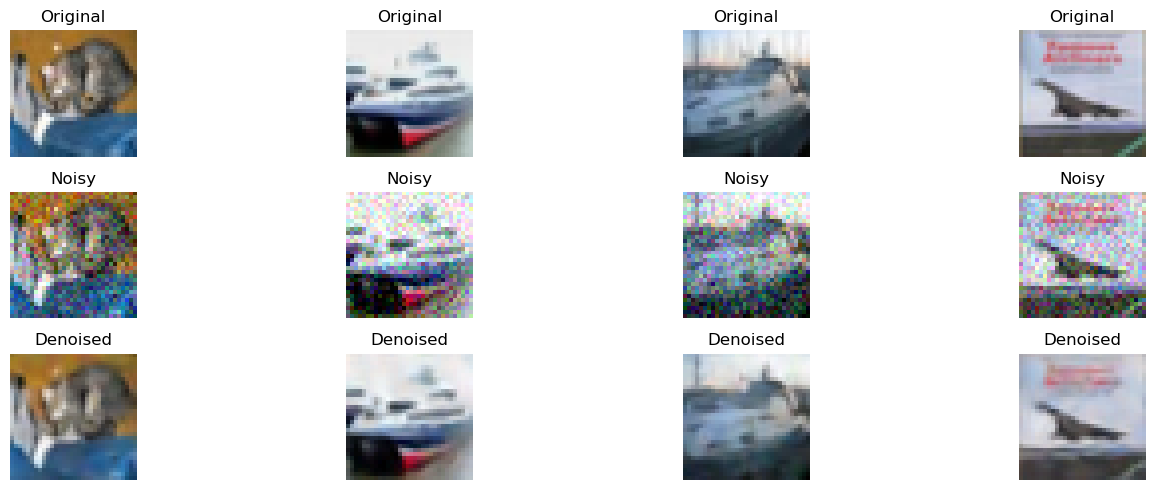

In [ ]:
# dataiter = iter(test_loader)
# images, _ = next(dataiter)
# images = images.to(device)
# noise = torch.randn_like(images) * noise_std
# noisy_images = images + noise
# denoised_images = model(noisy_images)

# images_np        = images.cpu().numpy().transpose(0,2,3,1)
# noisy_images_np  = noisy_images.cpu().numpy().transpose(0,2,3,1)
# denoised_np      = denoised_images.cpu().detach().numpy().transpose(0,2,3,1)

# num_show = 4
# plt.figure(figsize=(15, 5))
# for i in range(num_show):
#     plt.subplot(3, num_show, i+1)
#     plt.imshow(np.clip(images_np[i], 0, 1))
#     plt.title("Original")
#     plt.axis("off")

#     plt.subplot(3, num_show, i+1+num_show)
#     plt.imshow(np.clip(noisy_images_np[i], 0, 1))
#     plt.title("Noisy")
#     plt.axis("off")

#     plt.subplot(3, num_show, i+1+2*num_show)
#     plt.imshow(np.clip(denoised_np[i], 0, 1))
#     plt.title("Denoised")
#     plt.axis("off")

# plt.tight_layout()
# plt.show()
